### 산청군과 섬 지우기

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["figure.figsize"] = (10, 10)

import warnings
warnings.filterwarnings("ignore")

In [2]:
## 읍면동 공간데이터 불러오기
emd = gpd.read_file(
    "../data/emd_20230729/emd.shp", 
    encoding="cp949", 
    )

## 읍면동 경상남도 추출
emd = emd[emd["EMD_CD"].apply(lambda x: x[:2] == "48")]
emd_for_join = emd[emd["EMD_CD"].apply(lambda x: False if x[0:4] == "4886" else True)]
emd_for_join = emd_for_join[emd_for_join["EMD_KOR_NM"].apply(
    lambda x: False if x in ["한산면", "욕지면"] else True
    )]

## crs값 설정
emd = emd.set_crs(crs="EPSG:5179")

print(emd.crs)

EPSG:5179


In [3]:
## 정류장 데이터 불러오기
busstop = pd.read_csv("../data/버스기본데이터/국토교통부_전국 버스정류장 위치정보_20231016.csv", encoding="cp949")

## 경남만 불러오기
busstop = busstop[busstop["도시명"].apply(lambda x: True if "경상남도" in x else False)]

## 이상치 및 결측치 처리
busstop = busstop.drop(index=94785)
busstop.loc[140553, "위도"] = 34.927810
busstop.loc[140553, "경도"] = 128.06807
busstop.loc[140554, "위도"] = 34.927663
busstop.loc[140554, "경도"] = 128.06838

## geo data 형태로 변형
busstop = gpd.GeoDataFrame(
    busstop, 
    geometry=gpd.points_from_xy(busstop['경도'], busstop['위도'])
    )

## crs값 설정
busstop = busstop.set_crs(crs="EPSG:4326")
busstop = busstop.to_crs(epsg=5179)
print(busstop.crs)

EPSG:5179


##### 경상남도 내에 있는 버스 정류장 추출 

In [4]:
## busstop데이터의 point만 추출
busstop_points = busstop[["geometry"]]
## emd데이터의 polygon만 추출
emd_polygons = emd_for_join[["geometry"]]

## 공간 join 수행 (points와 polygons 간의 'within' 관계를 기반으로)
busstop_within_emd = gpd.sjoin(
    left_df=busstop_points, 
    right_df=emd_polygons, 
    how='inner', 
    predicate='within'
    )

## joined DataFrame에는 points와 일치하는 polygons의 정보가 포함됨
busstop_within_emd = busstop_within_emd.drop(columns='index_right')

## 원본 버스 정류장 데이터에 조인
busstop_within_emd = gpd.sjoin(
    left_df=busstop, 
    right_df=busstop_within_emd, 
    how="right", 
    )
busstop_within_emd = busstop_within_emd.drop(columns='index_left')

In [9]:
emd[emd["EMD_CD"] == "48121510"]

,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,geometry


In [26]:
busstop_within_emd

,index_left,정류장번호,정류장명,위도,경도,정보수집일,모바일단축번호,도시코드,도시명,관리도시명,geometry
10276,10276,CWB379000566,구암고등학교,35.246296,128.593978,2023-10-16,420615.0,38010,경상남도 창원시,창원,POINT (1099529.31 1695090.322)
10277,10277,CWB379000567,사격장입구,35.244923,128.683156,2023-10-16,107508.0,38010,경상남도 창원시,창원,POINT (1107644.846 1695031.102)
10278,10278,CWB379000568,장애인복지회관입구,35.244960,128.673597,2023-10-16,119117.0,38010,경상남도 창원시,창원,POINT (1106775.068 1695024.86)
10279,10279,CWB379000570,장애인복지회관입구,35.244773,128.673243,2023-10-16,119118.0,38010,경상남도 창원시,창원,POINT (1106743.105 1695003.68)
10280,10280,CWB379000573,지귀상가,35.244778,128.659437,2023-10-16,119111.0,38010,경상남도 창원시,창원,POINT (1105486.945 1694989.456)
...,...,...,...,...,...,...,...,...,...,...,...
203796,203796,YSB5166,사과나무집,35.491970,128.989600,2023-10-16,5166.0,38100,경상남도 양산시,양산,POINT (1135114.889 1722807.741)
203797,203797,YSB5167,이지더원3차,35.322630,129.027700,2023-10-16,5167.0,38100,경상남도 양산시,양산,POINT (1138861.264 1704077.947)
203798,203798,YSB5168,반도유보라6차,35.317890,129.027500,2023-10-16,5168.0,38100,경상남도 양산시,양산,POINT (1138851.189 1703551.929)
203799,203799,YSB5169,양우내안애6차,35.318010,129.023400,2023-10-16,5169.0,38100,경상남도 양산시,양산,POINT (1138478.261 1703559.5)


#### 노인 데이터 이상치 제거 (산청군, 한산면, 욕지면)

In [28]:
## 노인 밀집 구역
silver = pd.read_csv(
    filepath_or_buffer="../data/silver_centroid.csv"
)
silver = silver.dropna()
silver = gpd.GeoDataFrame(
    silver, 
    geometry=gpd.points_from_xy(silver['경도'], silver['위도'])
    ).set_crs(crs="EPSG:4326").to_crs(epsg=5179)
silver = silver.reset_index(drop=True)

In [32]:
## silver데이터의 point만 추출
silver_points = silver[["geometry"]]
## emd데이터의 polygon만 추출
emd_polygons = emd_for_join[["geometry"]]

## 공간 join 수행 (points와 polygons 간의 'within' 관계를 기반으로)
silver_within_emd = gpd.sjoin(
    left_df=silver_points, 
    right_df=emd_polygons, 
    how='inner', 
    predicate='within'
    )

## joined DataFrame에는 points와 일치하는 polygons의 정보가 포함됨
silver_within_emd = silver_within_emd.drop(columns='index_right')

## 원본 노인 데이터에 조인
silver_within_emd = gpd.sjoin(
    left_df=silver, 
    right_df=silver_within_emd, 
    how="right", 
    )
silver_within_emd = silver_within_emd.drop(columns='index_left')
silver_within_emd = silver_within_emd.reset_index(drop=True)

In [33]:
silver_within_emd

,gid,lbl,val,point,경도,위도,geometry
0,마라008419,7.0,7.0,POINT (1100850 1641950),128.602047,34.767065,POINT (1100850 1641950)
1,마라044519,20.0,20.0,POINT (1104450 1651950),128.642624,34.856861,POINT (1104450 1651950)
2,라라975559,26.0,26.0,POINT (1097550 1655950),128.567620,34.893611,POINT (1097550 1655950)
3,마라087557,13.0,13.0,POINT (1108750 1655750),128.690148,34.890670,POINT (1108750 1655750)
4,마라039555,15.0,15.0,POINT (1103950 1655550),128.637602,34.889370,POINT (1103950 1655550)
...,...,...,...,...,...,...,...
26618,라마600304,43.0,43.0,POINT (1060050 1730450),128.162679,35.568252,POINT (1060050 1730450)
26619,라마664324,6.0,6.0,POINT (1066450 1732450),128.233466,35.585875,POINT (1066450 1732450)
26620,라마710315,7.0,7.0,POINT (1071050 1731550),128.284157,35.577441,POINT (1071050 1731550)
26621,라마565506,6.0,6.0,POINT (1056550 1750650),128.125476,35.750580,POINT (1056550 1750650)


#### 시설 데이터 이상치 제거 (산청군, 한산면, 욕지면)

In [35]:
## 시설 위치
facility = pd.read_csv(
    filepath_or_buffer="../data/시설.csv"
)
facility = facility.dropna()
facility = gpd.GeoDataFrame(
    facility, 
    geometry=gpd.points_from_xy(facility['경도'], facility['위도'])
    ).set_crs(crs="EPSG:4326").to_crs(epsg=5179)
facility = facility.reset_index(drop=True)

In [36]:
## facility데이터의 point만 추출
facility_points = facility[["geometry"]]
## emd데이터의 polygon만 추출
emd_polygons = emd_for_join[["geometry"]]

## 공간 join 수행 (points와 polygons 간의 'within' 관계를 기반으로)
facility_within_emd = gpd.sjoin(
    left_df=facility_points, 
    right_df=emd_polygons, 
    how='inner', 
    predicate='within'
    )

## joined DataFrame에는 points와 일치하는 polygons의 정보가 포함됨
facility_within_emd = facility_within_emd.drop(columns='index_right')

## 원본 시설 데이터에 조인
facility_within_emd = gpd.sjoin(
    left_df=facility, 
    right_df=facility_within_emd, 
    how="right", 
    )
facility_within_emd = facility_within_emd.drop(columns='index_left')
facility_within_emd = facility_within_emd.reset_index(drop=True)

In [37]:
facility_within_emd

,시설구분,시설명,주소,경도,위도,geometry
0,공공시설,거제소방서,경상남도 거제시 진목로 1,128.686163,34.896160,POINT (1108378.585 1656354.546)
1,공공시설,거창소방서,경상남도 거창군 거창읍 거함대로 3324,127.923447,35.677620,POINT (1038319.146 1742460.38)
2,공공시설,고성소방서,경상남도 고성군 고성읍 남해안대로 2670,128.331066,34.981093,POINT (1075854.521 1665446.782)
3,공공시설,김해동부소방서,경상남도 김해시 김해대로 2507,128.901162,35.228565,POINT (1127506.042 1693474.999)
4,공공시설,김해서부소방서,경상남도 김해시 장유로 341,128.817396,35.196597,POINT (1119929.866 1689825.028)
...,...,...,...,...,...,...
18461,판매시설,장성중앙시장,경상남도 하동군 경서대로 2427-14,127.891709,35.113547,POINT (1035694.751 1679890.225)
18462,판매시설,홍천시장,경상남도 하동군 횡천면 문화2길 24,127.810894,35.109159,POINT (1028331.953 1679377.706)
18463,판매시설,제주시동문재래시장,경상남도 진주시 대곡면 진의로 1079번길 6,128.168556,35.263701,POINT (1060810.939 1696676.97)
18464,생활편익시설,마천분회경로당,경상남도 함양군 마천면 천왕봉로 1144-2,127.662681,35.395649,POINT (1014773.127 1711117.634)


In [41]:
# busstop_within_emd.to_csv("../data/busstop.csv", index=False)
# silver_within_emd.to_csv("../data/silver.csv", index=False)
# facility_within_emd.to_csv("../data/facility.csv", index=False)

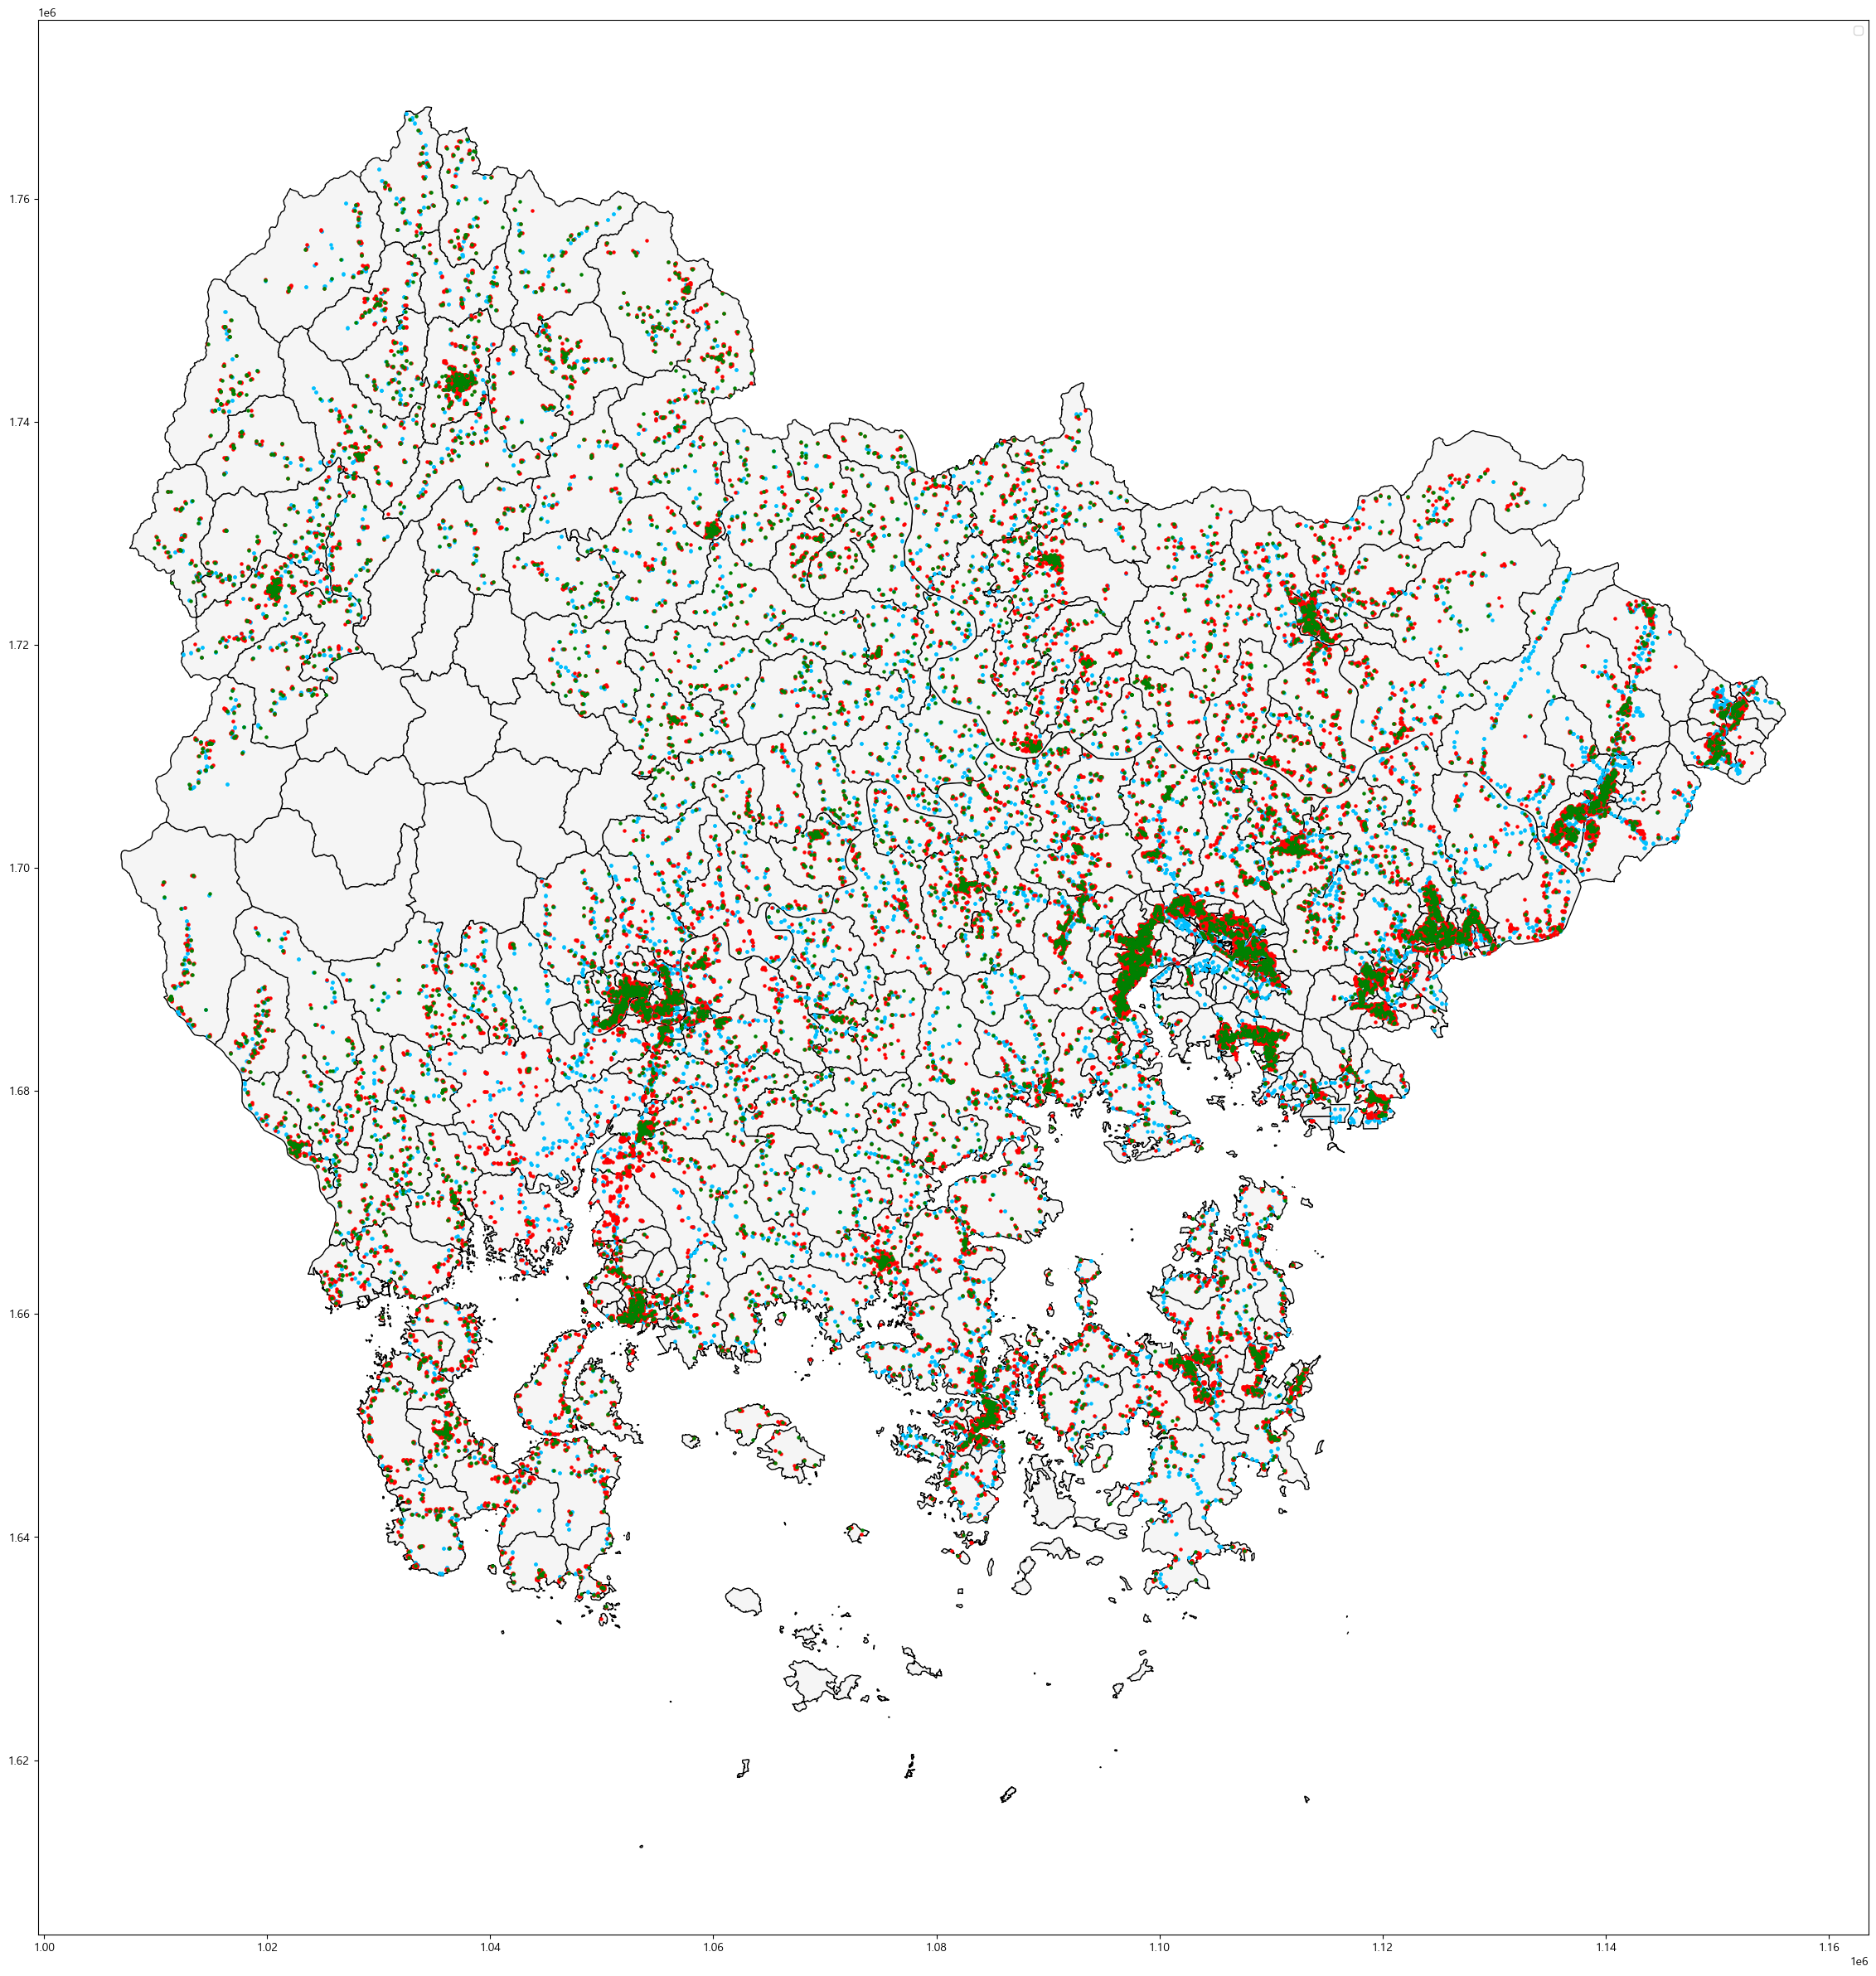

In [40]:
## 읍면동 틀 그리기
ax = emd.plot(
    figsize = (30, 30), 
    color = "whitesmoke", 
    edgecolor = "black", 
    linewidth = 1,
    column = "EMD_KOR_NM",
    legend = True, 
    categorical = True
)

## 버스 정류장 위치 확인
busstop_within_emd.plot(
    ax = ax, 
    color = "deepskyblue", 
    markersize = 5
)
## 노인 위치 확인
silver_within_emd.plot(
    ax = ax, 
    color = "red", 
    markersize = 5
)
## 시설 위치 확인
facility_within_emd.plot(
    ax = ax, 
    color = "green", 
    markersize = 5
)
plt.legend()
plt.show()